## Business Understanding
Our task for this lab is to create our own logistic regression model which is able to classify how many Uber pickups there will be (low, medium, or high) based off of different information in our dataset. The dataset is a collection of information about Uber pickups like time and location, joined with other data such as the weather for that time and location, what borough it is in, and whether or not it was a NYC public holiday. We split our predictions up by borough because certain boroughs like Manhattan generally always have a higher volume of pickups than boroughs like the Bronx, so aggregate predictions over all of NYC would not have been very insightful. Instead, we make predictions specific to each borough, with the exception of EWR and Staten Island, which we threw out because they did not contain enough data to make accurate predictions. We denote a "high" amount of pickups as greater than half a standard deviation above the mean for that borough. A "low" amount is less than half a standard deviation below the mean for that borough. A "medium" amount is inbetween. 

Our predicion task is valuable because it gives Uber insight into the time periods where they can be most profitable, and time periods where they can save money. For example, on New Years Eve there is most likely an extreme surge in the number of rides requested. If there are not enough drivers to satisfy all of these rides, people will go to Lyft or even just hail a yellow cab. However, if they prepare for this surge by incentivising drivers with an extra percentage of the ride money, there will be more drivers to satisfy the extra rides requests. Our model's insights would help pull in more profits and increases market share compared to treating every day and location as equally profitable. In production, this model would provide the best results if it were deployed so that it would run constantly and react to changing weather conditions, social movements, etc.

In [96]:
import numpy as np

## Data Prep

In [97]:
import pandas as pd
data = pd.read_csv("./data/uber_nyc_enriched.csv")

In [98]:
data.describe()

,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd
count,29101.000000,29101.000000,29101.000000,29101.000000,29101.000000,29101.000000,29101.000000,29101.000000,29101.000000,29101.000000
mean,490.215903,5.984924,8.818125,47.669042,30.823065,1017.817938,0.003830,0.026129,0.090464,2.529169
std,995.649536,3.699007,2.442897,19.814969,21.283444,7.768796,0.018933,0.093125,0.219402,4.520325
min,0.000000,0.000000,0.000000,2.000000,-16.000000,991.400000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,9.100000,32.000000,14.000000,1012.500000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,6.000000,10.000000,46.000000,30.000000,1018.200000,0.000000,0.000000,0.000000,0.000000
75%,449.000000,8.000000,10.000000,64.500000,50.000000,1022.900000,0.000000,0.000000,0.050000,2.958333
max,7883.000000,21.000000,10.000000,89.000000,73.000000,1043.400000,0.280000,1.240000,2.100000,19.000000


<p> checking for nan or null values in the dataset </p>

In [99]:
data.isnull().values.any()

True

<p> We found only Borough has nan values so we remove the nan rows </p>

In [100]:
data.isnull().any()

pickup_dt    False
borough       True
pickups      False
spd          False
vsb          False
temp         False
dewp         False
slp          False
pcp01        False
pcp06        False
pcp24        False
sd           False
hday         False
dtype: bool

In [101]:
data = data.dropna()

In [102]:
data.isnull().any()

pickup_dt    False
borough      False
pickups      False
spd          False
vsb          False
temp         False
dewp         False
slp          False
pcp01        False
pcp06        False
pcp24        False
sd           False
hday         False
dtype: bool

<p> We found that most of our data didnt have much correlation except temperate and the dew point temperature. We decided to get rid of this variable becasue it seemed very similar to temperature and did not think it would impact the machine learning. </p>

In [103]:
data.corr()

,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd
pickups,1.000000,0.009741,-0.008429,0.063692,0.040082,-0.015708,0.005007,-0.002821,-0.022935,-0.009676
spd,0.009741,1.000000,0.086177,-0.296126,-0.321606,-0.092761,-0.000357,0.016668,-0.010412,0.097041
vsb,-0.008429,0.086177,1.000000,0.025214,-0.231294,0.167039,-0.488407,-0.118346,0.000895,-0.047834
temp,0.063692,-0.296126,0.025214,1.000000,0.896544,-0.224537,-0.013343,-0.037295,-0.014408,-0.545558
dewp,0.040082,-0.321606,-0.231294,0.896544,1.000000,-0.311156,0.115399,0.013293,0.001519,-0.489372
slp,-0.015708,-0.092761,0.167039,-0.224537,-0.311156,1.000000,-0.089752,-0.104940,-0.134689,0.121508
pcp01,0.005007,-0.000357,-0.488407,-0.013343,0.115399,-0.089752,1.000000,0.128064,0.000997,0.000310
pcp06,-0.002821,0.016668,-0.118346,-0.037295,0.013293,-0.104940,0.128064,1.000000,0.251166,0.039943
pcp24,-0.022935,-0.010412,0.000895,-0.014408,0.001519,-0.134689,0.000997,0.251166,1.000000,0.069664
sd,-0.009676,0.097041,-0.047834,-0.545558,-0.489372,0.121508,0.000310,0.039943,0.069664,1.000000


In [104]:
del data['dewp']

<p> We made the holiday column count 1 for yes and 0 for no. </p>

In [105]:
data['hday'] = data['hday'].apply(lambda x: 0 if x=='N' else 1)

<p> We one hot encoded our boroughs becuase they were string values </p>

In [106]:
oneHotCols = pd.get_dummies(data['borough'])
data = data.join(oneHotCols)

In [107]:
del data['borough']

### 1 hot encoding the time of day

<p> We based our hour groups by sunrise and sunset. Night is the time when the sun is down, which on average is from 8pm to 6am. Morning is from 6am till noon. Afternoon is from noon till 5pm. Evening is from 5pm till 8pm, which is around when the sunsets. 

In [108]:
dateTest = data['pickup_dt'][0]
print(int(dateTest[11:13]))
data['is_morning'] = data['pickup_dt'].apply(lambda x: 1 if (int(x[11:13]) >= 6 and int(x[11:13]) < 12) else 0)
data['is_afternoon'] = data['pickup_dt'].apply(lambda x: 1 if (int(x[11:13]) >= 12 and int(x[11:13]) < 17) else 0)
data['is_evening'] = data['pickup_dt'].apply(lambda x: 1 if (int(x[11:13]) >= 17 and int(x[11:13]) < 21) else 0)
data['is_night']  = data['pickup_dt'].apply(lambda x: 1 if (int(x[11:13]) >= 21 or int(x[11:13]) < 6) else 0)

1


### 1 hot encoding the weekday

The weekday from the pickup_dt feature has been 1 hot encoded into monday-sunday. We believe having each day as a feature will help classify & predict the number of ubers necessary at a future date

In [109]:
import datetime
data['is_monday'] = data['pickup_dt'].apply(lambda x: 1 if datetime.date(int(x[0:4]),int(x[5:7]),int(x[8:10])).weekday() == 0 else 0)
data['is_tuesday'] = data['pickup_dt'].apply(lambda x: 1 if datetime.date(int(x[0:4]),int(x[5:7]),int(x[8:10])).weekday() == 1 else 0)
data['is_wednesday'] = data['pickup_dt'].apply(lambda x: 1 if datetime.date(int(x[0:4]),int(x[5:7]),int(x[8:10])).weekday() == 2 else 0)
data['is_thursday'] = data['pickup_dt'].apply(lambda x: 1 if datetime.date(int(x[0:4]),int(x[5:7]),int(x[8:10])).weekday() == 3 else 0)
data['is_friday'] = data['pickup_dt'].apply(lambda x: 1 if datetime.date(int(x[0:4]),int(x[5:7]),int(x[8:10])).weekday() == 4 else 0)
data['is_saturday'] = data['pickup_dt'].apply(lambda x: 1 if datetime.date(int(x[0:4]),int(x[5:7]),int(x[8:10])).weekday() == 5 else 0)
data['is_sunday'] = data['pickup_dt'].apply(lambda x: 1 if datetime.date(int(x[0:4]),int(x[5:7]),int(x[8:10])).weekday() == 6 else 0)

In [110]:
del data['pickup_dt']

<p> We found that the borough EWR averages about 2.4 pickups every 96 hours so we are getting rid of the EWR borough from our dataset. We found that the borough Staten Island averages 1.6 pickups and hour and had a max 13 pickups in an hour over 6 months so we got rid of it from our dataset. </p>

In [111]:
d1 = data.where(data['EWR']==1)[['pickups','EWR']]
print(d1.describe())
d1 = d1.dropna()
data = data[data.EWR == 0]
del data['EWR']
d1 = data.where(data['Staten Island']==1)[['pickups','Staten Island']]
print(d1.describe())
d1 = d1.dropna()
data = data[data['Staten Island'] == 0]
del data['Staten Island']

           pickups     EWR
count  4343.000000  4343.0
mean      0.024177     1.0
std       0.160937     0.0
min       0.000000     1.0
25%       0.000000     1.0
50%       0.000000     1.0
75%       0.000000     1.0
max       2.000000     1.0
           pickups  Staten Island
count  4343.000000         4343.0
mean      1.601888            1.0
std       1.640451            0.0
min       0.000000            1.0
25%       0.000000            1.0
50%       1.000000            1.0
75%       2.000000            1.0
max      13.000000            1.0


## Making our Categories

<p> We have three cateogries of pickup traffic low, medium, high. We found these by finding the mean and standard deviation of each borough. Low is half a standard deviation below the mean and high is half a stadard deviation above the mean. Anything else is counted as a medium amount of pickups. This means that the category of low, medium, and high pickup amount depends on the borough. If we did base our categories by borough then Manhattan would always be in the high pickup amount category and Queens would always be in the low pickup amount category.  </p> 

In [112]:
Man = data[data.Manhattan == 1]
Bronx = data[data.Bronx == 1]
Queens = data[data.Queens == 1]
Brooklyn = data[data.Brooklyn == 1]

print(Man['pickups'].describe())
print(Bronx['pickups'].describe())
print(Queens['pickups'].describe())
print(Brooklyn['pickups'].describe())

count    4343.000000
mean     2387.253281
std      1434.724668
min         0.000000
25%      1223.500000
50%      2269.000000
75%      3293.500000
max      7883.000000
Name: pickups, dtype: float64
count    4343.000000
mean       50.667050
std        31.029223
min         0.000000
25%        29.000000
50%        46.000000
75%        66.000000
max       262.000000
Name: pickups, dtype: float64
count    4343.000000
mean      309.354824
std       154.368300
min         0.000000
25%       196.000000
50%       308.000000
75%       410.000000
max       831.000000
Name: pickups, dtype: float64
count    4343.000000
mean      534.431269
std       294.810182
min         0.000000
25%       331.500000
50%       493.000000
75%       675.000000
max      2009.000000
Name: pickups, dtype: float64


<p> Using the mean and stadard deviation of each borough to place each row of data into a category. We can see that our categories are almost completely balanced within each borough.  </p> 

In [113]:
mstd = Man['pickups'].std()
mmean = Man['pickups'].mean()
Man['pickupPrediction'] = Man['pickups'].apply(lambda x: 0 if x < (mmean - mstd/2) else (
                                               2 if (x > (mmean + mstd/2))
                                                else 1))
print(Man['pickupPrediction'].describe())

mstd = Bronx['pickups'].std()
mmean = Bronx['pickups'].mean()
Bronx['pickupPrediction'] = Bronx['pickups'].apply(lambda x: 0 if x < (mmean - mstd/2) else (
                                               2 if (x > (mmean + mstd/2))
                                                else 1))
print(Bronx['pickupPrediction'].describe())

mstd = Queens['pickups'].std()
mmean = Queens['pickups'].mean()
Queens['pickupPrediction'] = Queens['pickups'].apply(lambda x: 0 if x < (mmean - mstd/2) else (
                                               2 if (x > (mmean + mstd/2))
                                                else 1))
print(Queens['pickupPrediction'].describe())

mstd = Brooklyn['pickups'].std()
mmean = Brooklyn['pickups'].mean()
Brooklyn['pickupPrediction'] = Brooklyn['pickups'].apply(lambda x: 0 if x < (mmean - mstd/2) else (
                                               2 if (x > (mmean + mstd/2))
                                                else 1))
print(Brooklyn['pickupPrediction'].describe())

count    4343.000000
mean        0.953028
std         0.774480
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         2.000000
Name: pickupPrediction, dtype: float64
count    4343.000000
mean        0.907898
std         0.757453
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: pickupPrediction, dtype: float64
count    4343.000000
mean        0.980428
std         0.794867
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         2.000000
Name: pickupPrediction, dtype: float64
count    4343.000000
mean        0.901911
std         0.757005
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: pickupPrediction, dtype: float64


//anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
//anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
//anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a co

In [114]:
from sklearn.model_selection import train_test_split
yMan = Man['pickupPrediction']
del Man['pickupPrediction']
yBronx = Bronx['pickupPrediction']
del Bronx['pickupPrediction']
yQueens = Queens['pickupPrediction']
del Queens['pickupPrediction']
yBrooklyn = Brooklyn['pickupPrediction']
del Brooklyn['pickupPrediction']

<p> Splitting our data in each borough before we combine our data again. This lets us have an even amount of each borough in the train and test dataset.  </p>

In [115]:
xManTrain, xManTest, yManTrain, YManTest = train_test_split(Man, yMan, test_size = 1/5, random_state = 0)
xBronxTrain, xBronxTest, yBronxTrain, YBronxTest = train_test_split(Bronx, yBronx, test_size = 1/5, random_state = 0)
xQueensTrain, xQueensTest, yQueensTrain, YQueensTest = train_test_split(Queens, yQueens, test_size = 1/5, random_state = 0)
xBrooklynTrain, xBrooklynTest, yBrooklynTrain, YBrooklynTest = train_test_split(Brooklyn, yBrooklyn, test_size = 1/5, random_state = 0)
xTrain = pd.concat([xManTrain,xBronxTrain,xQueensTrain,xBrooklynTrain])
xTest = pd.concat([xManTest,xBronxTest,xQueensTest,xBrooklynTest])
yTrain = pd.concat([yManTrain,yBronxTrain,yQueensTrain,yBrooklynTrain])
yTest = pd.concat([YManTest,YBronxTest,YQueensTest,YBrooklynTest])

<p>Putting our values of the pandas dataframe into arrays so that the index isn't taken as a feature during our machine learning. </p>

In [116]:
from sklearn.preprocessing import StandardScaler

xTrain.reset_index(inplace=True, drop=True)
yTrain.reset_index(inplace=True, drop=True)
xTest.reset_index(inplace=True, drop=True)
yTest.reset_index(inplace=True, drop=True)
xTrain = xTrain.values
yTrain = yTrain.values
xTest = xTest.values
yTest = yTest.values
xTrain = StandardScaler().fit(xTrain).transform(xTrain)
XTest = StandardScaler().fit(xTest).transform(xTest)

<p> Our modified version of the Binaray Logistic Regression from class. </p>

In [290]:
from scipy.special import expit
class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, L1C=0.001,L2C=0.001):
        self.eta = eta
        self.iters = iterations
        self.L1C = L1C
        self.L2C = L2C
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
       
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        if(self.L1C > 0 and self.L2C > 0):
            gradient[1:] += -2 * (np.sign(self.w_[1:]) * self.L1C + self.w_[1:] * self.L2C)
        elif(self.L1C > 0):
            gradient[1:] += -2 * np.sign(self.w_[1:]) * self.L1C 
        elif(self.L2C > 0):
            gradient[1:] += (-2 * self.w_[1:] * self.L2C)
        else:
            gradient[1:] += -2 * self.w_[1:] 
        return gradient
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 
            # add bacause maximizing 

<p> Our modified version of the Stochastic Logistic Regression from class. </p>

In [291]:
class StochasticLogisticRegression(BinaryLogisticRegression):
    # stochastic gradient calculation 
    def _get_gradient(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        if(self.L1C > 0 and self.L2C > 0):
            gradient[1:] += -2 * (np.sign(self.w_[1:]) * self.L1C + self.w_[1:] * self.L2C)
        elif(self.L1C > 0):
            gradient[1:] += -2 * np.sign(self.w_[1:]) * self.L1C 
        elif(self.L2C > 0):
            gradient[1:] += (-2 * self.w_[1:] * self.L2C)
        else:
            gradient[1:] += -2 * self.w_[1:] 
        
        return gradient

<p> Our modified version of the Line Search Logistic Regression from class. </p>

In [292]:
from scipy.optimize import minimize_scalar
import copy
class LineSearchLogisticRegression(BinaryLogisticRegression):
    
    # define custom line search for problem
    @staticmethod
    def objective_function(eta,X,y,w,grad,L1C,L2C):
        wnew = w - grad*eta
        g = expit(X @ wnew)
        if(L1C > 0 and L2C > 0):
            wobj = -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + L1C*sum(abs(wnew)) + L2C*sum(wnew**2)
        elif(L1C > 0):
            wobj = -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + L1C*sum(abs(wnew))
        else:
            wobj = -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + L2C*sum(wnew**2)
        return wobj
    
        
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = -self._get_gradient(Xb,y)
            # minimization inopposite direction
            
            # do line search in gradient direction, using scipy function
            opts = {'maxiter':self.iters/50} # unclear exactly what this should be
            res = minimize_scalar(self.objective_function, # objective function to optimize
                                  bounds=(self.eta/1000,self.eta*10), #bounds to optimize
                                  args=(Xb,y,self.w_,gradient,self.L1C,self.L2C), # additional argument for objective function
                                  method='bounded', # bounded optimization for speed
                                  options=opts) # set max iterations
            
            eta = res.x # get optimal learning rate
            self.w_ -= gradient*eta # set new function values
            # subtract to minimize
                

<p> Our modified version of the BFGS Binary Logistic Regression from class. </p>

In [293]:
from scipy.optimize import fmin_bfgs
class BFGSBinaryLogisticRegression(BinaryLogisticRegression):
    
    @staticmethod
    def objective_function(w,X,y,C,regul):
        g = expit(X @ w)
        return -np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    @staticmethod
    def objective_gradient(w,X,y,L1C,L2C):
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        if(L1C > 0 and L2C > 0):
            gradient[1:] += -2 * (np.sign(w[1:]) * L1C + w[1:] * L2C)
        elif(self.L1C > 0):
            gradient[1:] += -2 * np.sign(w[1:]) * L1C 
        elif(self.L2C > 0):
            gradient[1:] += (-2 * w[1:] * L2C)
        else:
            gradient[1:] += -2 * w[1:] 
        return -gradient
    
    # just overwrite fit function
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.L1C,self.L2C), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        
        self.w_ = self.w_.reshape((num_features,1))

<p> Our modified version of the Logistic Regression from class. </p>

In [294]:
class LogisticRegression:
    def __init__(self, eta, iterations=20,method='none',LC1=0.01,LC2=0.01):
        self.eta = eta
        self.iters = iterations
        self.method = method
        self.LC1 = LC1
        self.LC2 = LC2
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = (y==yval) # create a binary problem
            # train the binary classifier for this class
            if(self.method == 'none'):
                blr = BinaryLogisticRegression(self.eta,self.iters,self.LC1,self.LC2)
            elif(self.method == 'stoc'):
                blr = StochasticLogisticRegression(self.eta,self.iters,self.LC1,self.LC2)
            elif(self.method=='steep'):
                blr=LineSearchLogisticRegression(self.eta,self.iters,self.LC1,self.LC2)
            elif(self.method=='newt'):
                blr = BFGSBinaryLogisticRegression(self.eta,self.iters,self.LC1,self.LC2)
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X)) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row

## Binary Logistic Regression

### parameters go in order eta, iterations, method of regression, L1 Regularization Cost, L2 regularization Cost

In [295]:
from sklearn.metrics import accuracy_score
lr = LogisticRegression(0.1,500,'none',0.01,0.01)
%time lr.fit(xTrain,yTrain)

yhat = lr.predict(xTest)
print('Accuracy of: ',accuracy_score(yTest,yhat))

CPU times: user 3.72 s, sys: 61.8 ms, total: 3.78 s
Wall time: 994 ms
Accuracy of:  0.2799194476409666


## steepest descent

In [296]:
lr = LogisticRegression(0.01,100,'steep',0.001,0.001)
%time lr.fit(xTrain,yTrain)

yhat = lr.predict(xTest)
print('Accuracy of: ',accuracy_score(yTest,yhat))

CPU times: user 2.27 s, sys: 29.8 ms, total: 2.3 s
Wall time: 582 ms
Accuracy of:  0.371403912543153


## stochastic-gradient descent

In [297]:
lr = LogisticRegression(0.1,1000,'stoc',0.001,0.001)
%time lr.fit(xTrain,yTrain)

yhat = lr.predict(xTest)
print('Accuracy of: ',accuracy_score(yTest,yhat))

CPU times: user 385 ms, sys: 20.8 ms, total: 406 ms
Wall time: 102 ms
Accuracy of:  0.4194476409666283


## quasi newton method

In [298]:
lr = LogisticRegression(0.01,50,'newt',0.001,0.001)
%time lr.fit(xTrain,yTrain)

yhat = lr.predict(xTest)
print('Accuracy of: ',accuracy_score(yTest,yhat))

CPU times: user 1.18 s, sys: 14.6 ms, total: 1.19 s
Wall time: 302 ms
Accuracy of:  0.2799194476409666


## Grid Search

<p> We tried every technique with every combination of 10 ,1 ,0.1 ,0.01 ,0.001, and 0.0001 for L1 and L2 regularization </p> 

In [299]:
techniques = ['none','steep','stoc','newt']
vals = [10,1,0.1,0.01,0.001,0.0001]
maxNone = [0,0,0]
maxSteep = [0,0,0]
maxStoc = [0,0,0]
maxNewt = [0,0,0]
maxVal = [0,0,0,'test']
noney = [[],[],[],[],[],[]]
steepy =  [[],[],[],[],[],[]]
stocy =  [[],[],[],[],[],[]]
newty =  [[],[],[],[],[],[]]

for tech in techniques:
    i = 0
    for val in vals:
        for val2 in vals:
            lr = LogisticRegression(0.01,50,tech,val,val2)
            lr.fit(xTrain,yTrain)
            yhat = lr.predict(xTest)
            score = accuracy_score(yTest,yhat)
            if(tech == 'none'):
                noney[i].append(score)
                if(score > maxNone[0]):
                    maxNone[0] = score
                    maxNone[1] = val
                    maxNone[2] = val2
            if(tech == 'steep'):
                steepy[i].append(score)
                if(score > maxSteep[0]):
                    maxSteep[0] = score
                    maxSteep[1] = val
                    maxSteep[2] = val2
            if(tech == 'stoc'):
                stocy[i].append(score)
                if(score > maxStoc[0]):
                    maxStoc[0] = score
                    maxStoc[1] = val
                    maxStoc[2] = val2
            if(tech == 'newt'):
                newty[i].append(score)
                if(score > maxNewt[0]):
                    maxNewt[0] = score
                    maxNewt[1] = val
                    maxNewt[2] = val2
            if(score > maxVal[0]):
                maxVal[0] = score
                maxVal[1] = val
                maxVal[2] = val2
                maxVal[3] = tech
        i+=1          

//anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
//anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
//anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys
//anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
//anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys
//anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
//anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encoun

In [300]:
import matplotlib.pyplot as plt
%matplotlib inline

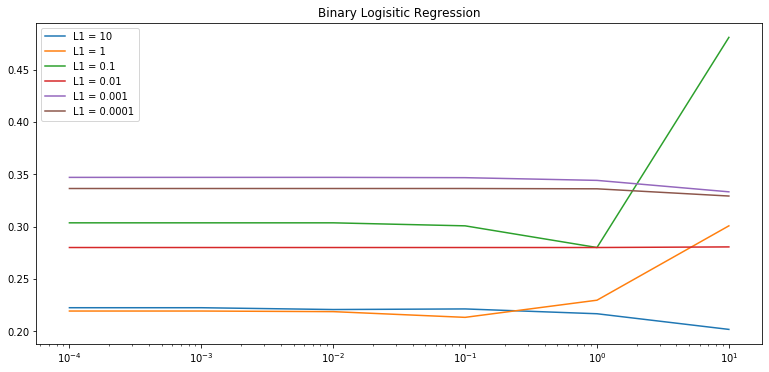

In [301]:
noneX = [10,1,0.1,0.01,0.001,0.0001]
fig = plt.figure(1, figsize=(13,13))
ax2  = fig.add_subplot(212)
for i in noney:
    plt.plot(noneX, i) #we plot y as a function of a, which parametrizes x
ax2.set_xscale('log', basex=10)
ax2.set_title('Binary Logisitic Regression')
ax2.legend(['L1 = 10', 'L1 = 1', 'L1 = 0.1', 'L1 = 0.01','L1 = 0.001', 'L1 = 0.0001'], loc='best')

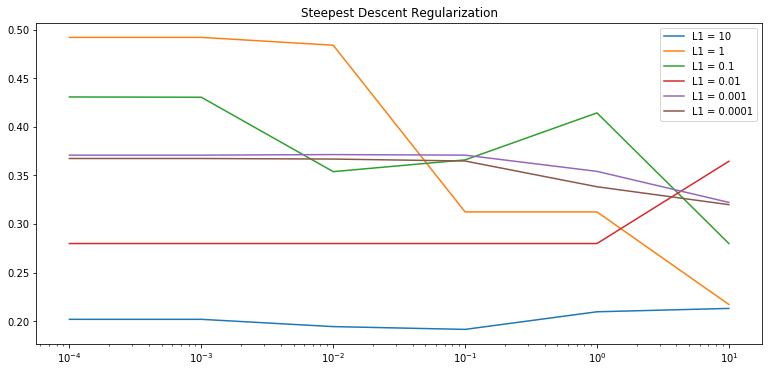

In [302]:
fig = plt.figure(1, figsize=(13,13))
ax2  = fig.add_subplot(212)
for i in steepy:
    ax2.plot(noneX, i) #we plot y as a function of a, which parametrizes x
ax2.set_xscale('log', basex=10)
ax2.set_title('Steepest Descent Regularization')
ax2.legend(['L1 = 10', 'L1 = 1', 'L1 = 0.1', 'L1 = 0.01','L1 = 0.001', 'L1 = 0.0001'], loc='best')

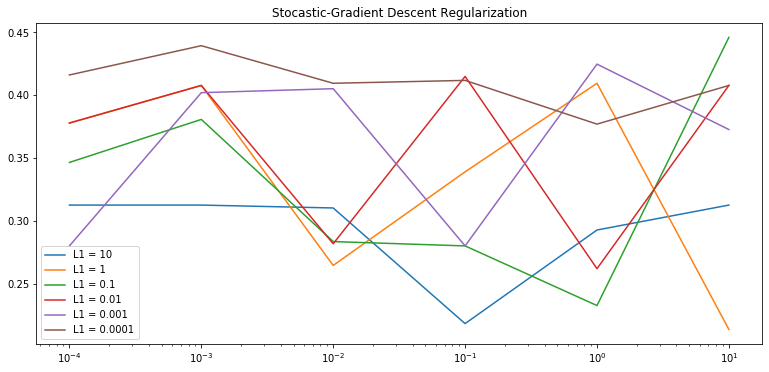

In [303]:
fig = plt.figure(1, figsize=(13,13))
ax2  = fig.add_subplot(212)
for i in stocy:
    ax2.plot(noneX, i) #we plot y as a function of a, which parametrizes x
ax2.set_xscale('log', basex=10)
ax2.set_title('Stocastic-Gradient Descent Regularization')
ax2.legend(['L1 = 10', 'L1 = 1', 'L1 = 0.1', 'L1 = 0.01','L1 = 0.001', 'L1 = 0.0001'], loc='best')

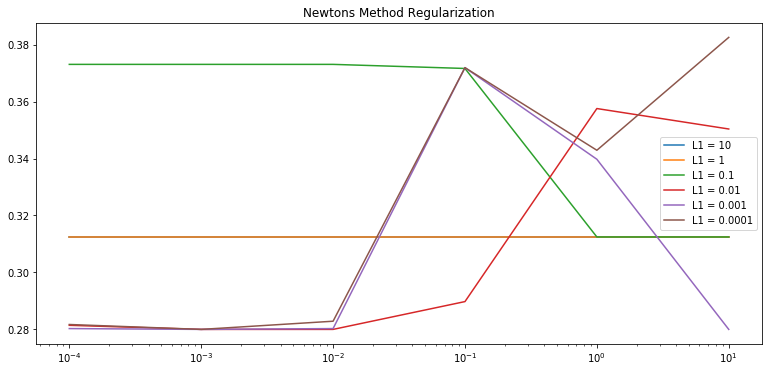

In [306]:
fig = plt.figure(1, figsize=(13,13))
ax2  = fig.add_subplot(212)
for i in newty:
    ax2.plot(noneX, i) #we plot y as a function of a, which parametrizes x
ax2.set_xscale('log', basex=10)
ax2.set_title('Newtons Method Regularization')
ax2.legend(['L1 = 10', 'L1 = 1', 'L1 = 0.1', 'L1 = 0.01','L1 = 0.001', 'L1 = 0.0001'], loc='best')

In [307]:
print('max for regular lr', maxNone[0],' L1:',maxNone[1],' L2:',maxNone[2])
print('max for steep', maxSteep[0],' L1:',maxSteep[1],' L2:',maxSteep[2])
print('max for stocastic',  maxStoc[0],' L1:',maxStoc[1],' L2:',maxStoc[2])
print('max for newton\'s', maxNewt[0],' L1:',maxNewt[1],' L2:',maxNewt[2])
print('max overall', maxVal[0],' L1:',maxVal[1],' L2:',maxVal[2], ' Techique:', maxVal[3])

max for regular lr 0.48072497123130037  L1: 0.1  L2: 10
max for steep 0.4919447640966628  L1: 1  L2: 0.001
max for stocastic 0.44591484464902187  L1: 0.1  L2: 10
max for newton's 0.38262370540851554  L1: 0.0001  L2: 10
max overall 0.4919447640966628  L1: 1  L2: 0.001  Techique: steep


<p> After testing each of our methods of regression, we found the steepest descent worked best on our data. Steepest Descent worked best with both L1 and L2 regularization. The cost for L1 was 1 and the cost for L2 was 0.001.   Stocastic and Binary Logistic regression were close in accuracy to Steepest Descent, which means we should keep them in mind as a method if we did more work on the dataset.</p>

<p> We believe that this is data snooping because we are testing every combination and picking the best. Also, from the charts we can see that there is no real pattern based around cost value or method. </p>

## Comparing Our Implementation to SciKitLearn

In [308]:
# how do we compare now to sklearn?
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression as LogisticRegressionSci
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
#From Sklearn documentation 
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = list(unique_labels(y_true, y_pred))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


Accuracy of:  0.334867663981588
[2 2 2 ... 2 2 2]
Confusion matrix, without normalization
[[ 394   90  602]
 [ 362    0 1055]
 [ 134   69  770]]


//anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


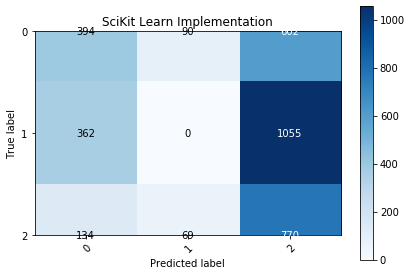

In [309]:
lr_sk = LogisticRegressionSci(C=0.00001) # all params default
# note that sklearn is optimized for using the liblinear library with logistic regression
# ...and its faster than our implementation here
lr_sk.fit(xTrain,yTrain) # no need to add bias term, sklearn does it internally!!
yhat = lr_sk.predict(xTest)
print('Accuracy of: ',accuracy_score(yTest,yhat))
# Plot non-normalized confusion matrix
class_names = ['low','medium','high']
print(yhat)
plot_confusion_matrix(yTest, yhat, classes=class_names,
                      title='SciKit Learn Implementation')

CPU times: user 1.2 s, sys: 27.5 ms, total: 1.22 s
Wall time: 318 ms
Accuracy of:  0.4919447640966628
Confusion matrix, without normalization
[[728 219 139]
 [516 560 341]
 [230 321 422]]


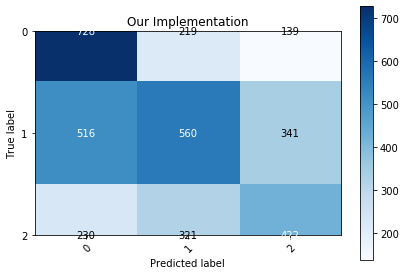

In [310]:
lr = LogisticRegression(0.01,50,'steep',1,0.001)
%time lr.fit(xTrain,yTrain)

yhat = lr.predict(xTest)
print('Accuracy of: ',accuracy_score(yTest,yhat))
plot_confusion_matrix(yTest, yhat, classes=class_names,
                      title='Our Implementation')

## Exceptional Work

In [311]:
from scipy.special import expit
class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, L1C=0.001,L2C=0.001):
        self.eta = eta
        self.iters = iterations
        self.L1C = L1C
        self.L2C = L2C
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        if(self.L1C > 0 and self.L2C > 0):
            gradient[1:] += -2 * (np.sign(self.w_[1:]) * self.L1C + self.w_[1:] * self.L2C)
        elif(self.L1C > 0):
            gradient[1:] += -2 * np.sign(self.w_[1:]) * self.L1C 
        elif(self.L2C > 0):
            gradient[1:] += (-2 * self.w_[1:] * self.L2C)
        else:
            gradient[1:] += -2 * self.w_[1:] 
        return gradient
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 
            # add bacause maximizing 

In [340]:
from itertools import combinations
class LogisticRegressionEW:
    def __init__(self, eta, iterations=20,method='none',LC1=0.01,LC2=0.01):
        self.eta = eta
        self.iters = iterations
        self.method = method
        self.LC1 = LC1
        self.LC2 = LC2
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
    def split_data(self,X,y,classes):
        newY = []
        newX = []
        for i in range(0,classes):
            newY.append([])
            newX.append([])
        for i in range(0,len(X)):
            ans = y[i]
            newX[ans].append(X[i])
        return newX
            
            
    
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        data = self.split_data(X,y,num_unique_classes)
        self.classifiers_ = [] # will fill this array with binary classifiers
        pairs = ["".join(map(str, comb)) for comb in combinations(self.unique_, 2)]
        temp = []
        for i in pairs:
            temp.append((int(i[0]),int(i[1])))
        pairs = temp
        for i in pairs: # for each unique value
            # train the binary classifier for this class
            if(self.method == 'none'):
                blr = BinaryLogisticRegression(self.eta,self.iters,self.LC1,self.LC2)
            elif(self.method == 'stoc'):
                blr = StochasticLogisticRegression(self.eta,self.iters,self.LC1,self.LC2)
            elif(self.method=='steep'):
                blr=LineSearchLogisticRegression(self.eta,self.iters,self.LC1,self.LC2)
            elif(self.method=='newt'):
                blr = BFGSBinaryLogisticRegression(self.eta,self.iters,self.LC1,self.LC2)
            X = np.vstack([data[i[0]],data[i[1]]])
            y = np.concatenate((np.full((len(data[i[0]]), 1), i[0]),np.full((len(data[i[1]]), 1), i[1])),axis=None)
            print(i)
            blr.fit(X,y)
            # add the trained classifier to the list
            self.classifiers_.append((blr,i))
        print(self.classifiers_)
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x[0].w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X,classifier):
        probs = []
        
        probs.append(classifier[0].predict_proba(np.array([x[1] for x in X]))) # get probability for each classifier
        
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X,ind):
        newX = []
        if(ind==0):
            for i,val in enumerate(X):
                newX.append((i,val))
        else:
            newX=X
        print('xdata length', len(newX))
        print('classifier index', ind)
        
        results = (self.predict_proba(newX,self.classifiers_[ind]))
        mean = ( self.classifiers_[ind][1][0] + self.classifiers_[ind][1][1]) /2
        print('mean: ',mean)

        #win means right child
        #lose means left child
        newXwin = [(newX[i]) for i,x in enumerate(results) if x[0] > mean]
        newXlose = [(newX[i]) for i,x in enumerate(results) if x[0] < mean]

        print('winners ',len(newXwin))
        print('losers', len(newXlose))
        # while a pair of children exist
        if(ind*2+2 <= len(self.classifiers_)-1):
            if(len(newXwin)>0):
                winners = np.array(self.predict(newXwin,ind*2+2))
            else:
                winners=np.array([])
            if(len(newXlose)>0):
                losers = np.array(self.predict(newXlose,ind*2+1))
            else:
                losers=np.array([])
                
            #returns original x indexes with winners and losers side
            return (([z[0] for z in newXwin],winners), ([z[0] for z in newXlose],losers))
        else:
            return results
            
        
            

#         return (self.predict_proba(X),axis=1) # take argmax along row

In [342]:
lr = LogisticRegressionEW(0.01,100,'steep',0.001,0.001)
%time lr.fit(xTrain,yTrain)

yhat = lr.predict(xTest,0)
yhatval = np.concatenate((yhat[0][1].flatten().astype(int), yhat[1][1].flatten().astype(int)),axis = None)
yhatindex = np.concatenate((yhat[0][0], yhat[1][0]),axis = None)
srted = np.array([x for _,x in sorted(zip(yhatindex,yhatval))])


## accuracy broken
print('Accuracy of: ',accuracy_score(yTest,srted))

(0, 1)
(0, 2)
(1, 2)
[(<__main__.LineSearchLogisticRegression object at 0x1a1f8db390>, (0, 1)), (<__main__.LineSearchLogisticRegression object at 0x1a1f8b0f10>, (0, 2)), (<__main__.LineSearchLogisticRegression object at 0x1a1c792d10>, (1, 2))]
CPU times: user 1.98 s, sys: 34.5 ms, total: 2.01 s
Wall time: 527 ms
xdata length 3476
classifier index 0
mean:  0.5
winners  2870
losers 606
xdata length 2870
classifier index 2
mean:  1.5
winners  0
losers 2870
xdata length 606
classifier index 1
mean:  1.0
winners  0
losers 606
Accuracy of:  0.4254890678941312


In [250]:
(13896, 25)
(13896,)


(13896,)